In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
warnings.filterwarnings('ignore')


In [2]:
# ## 1. Sparse Vektörleri ve Etiketleri Yükleme

# %% [code]
print("🔄 Sparse vektörler ve etiketler yükleniyor...")

# Sparse BoW vektörlerini yükle
try:
    X_bow = sp.load_npz('../data/X_bow_full_sparse.npz')
    print(f"✅ BoW vektörleri yüklendi: {X_bow.shape}")
    print(f"📊 BoW Sparse Ratio: {(1 - X_bow.nnz / (X_bow.shape[0] * X_bow.shape[1])) * 100:.2f}% sıfır değer")
except Exception as e:
    print(f"❌ BoW vektörleri yüklenirken hata: {e}")
    exit()

# Sparse TF-IDF vektörlerini yükle
try:
    X_tfidf = sp.load_npz('../data/X_tfidf_full_sparse.npz')
    print(f"✅ TF-IDF vektörleri yüklendi: {X_tfidf.shape}")
    print(f"📊 TF-IDF Sparse Ratio: {(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])) * 100:.2f}% sıfır değer")
except Exception as e:
    print(f"❌ TF-IDF vektörleri yüklenirken hata: {e}")
    exit()

# Etiketleri yükle
try:
    y = pd.read_csv('../data/labels.csv')['sentiment']
    # Etiketleri sayısal formata çevir
    y = y.map({'positive': 1, 'negative': 0})
    print(f"✅ Etiketler yüklendi: {y.shape}")
    print(f"📊 Sınıf dağılımı: {y.value_counts().to_dict()}")
except Exception as e:
    print(f"❌ Etiketler yüklenirken hata: {e}")
    exit()

# Boyut kontrolü
assert X_bow.shape[0] == X_tfidf.shape[0] == len(y), "Vektör ve etiket boyutları uymuyor!"
print(f"✅ Boyut kontrolü tamamlandı: {X_bow.shape[0]} örnek")


🔄 Sparse vektörler ve etiketler yükleniyor...
✅ BoW vektörleri yüklendi: (50000, 29165)
📊 BoW Sparse Ratio: 99.69% sıfır değer
✅ TF-IDF vektörleri yüklendi: (50000, 29165)
📊 TF-IDF Sparse Ratio: 99.69% sıfır değer
✅ Etiketler yüklendi: (50000,)
📊 Sınıf dağılımı: {1: 25000, 0: 25000}
✅ Boyut kontrolü tamamlandı: 50000 örnek


In [3]:
# ## 2. Veriyi Eğitim ve Test Setlerine Ayırma

# %% [code]
print("\n🔄 Veri eğitim ve test setlerine ayrılıyor...")

# BoW için train-test split
X_bow_train, X_bow_test, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF için train-test split (aynı random_state ile aynı bölünme)
X_tfidf_train, X_tfidf_test, _, _ = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Eğitim seti boyutu: {X_bow_train.shape[0]} örnek")
print(f"✅ Test seti boyutu: {X_bow_test.shape[0]} örnek")
print(f"✅ Toplam özellik sayısı (BoW): {X_bow_train.shape[1]}")
print(f"✅ Toplam özellik sayısı (TF-IDF): {X_tfidf_train.shape[1]}")

# Eğitim setindeki sınıf dağılımı
print(f"📊 Eğitim seti sınıf dağılımı: {y_train.value_counts().to_dict()}")
print(f"📊 Test seti sınıf dağılımı: {y_test.value_counts().to_dict()}")



🔄 Veri eğitim ve test setlerine ayrılıyor...
✅ Eğitim seti boyutu: 40000 örnek
✅ Test seti boyutu: 10000 örnek
✅ Toplam özellik sayısı (BoW): 29165
✅ Toplam özellik sayısı (TF-IDF): 29165
📊 Eğitim seti sınıf dağılımı: {1: 20000, 0: 20000}
📊 Test seti sınıf dağılımı: {0: 5000, 1: 5000}


In [4]:
# ## 3. Modelleri Eğitme (Tüm Veri Seti ile)

# %% [code]
print("\n🔄 Modeller eğitiliyor...")

# Sonuçları saklamak için dictionary
results = {}
models = {}

# 1. Naive Bayes (BoW) - Sparse matrislerle çalışır
print("🤖 Naive Bayes (BoW) eğitiliyor...")
start_time = datetime.now()
nb_bow = MultinomialNB()
nb_bow.fit(X_bow_train, y_train)
y_pred_nb_bow = nb_bow.predict(X_bow_test)
training_time = (datetime.now() - start_time).total_seconds()
models['Naive Bayes (BoW)'] = {'model': nb_bow, 'predictions': y_pred_nb_bow, 'training_time': training_time}
print(f"✅ Naive Bayes (BoW) eğitildi ({training_time:.2f} saniye)")

# 2. Lojistik Regresyon (BoW) - Sparse matrislerle çalışır
print("🤖 Lojistik Regresyon (BoW) eğitiliyor...")
start_time = datetime.now()
lr_bow = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')  # liblinear sparse için daha iyi
lr_bow.fit(X_bow_train, y_train)
y_pred_lr_bow = lr_bow.predict(X_bow_test)
training_time = (datetime.now() - start_time).total_seconds()
models['Lojistik Regresyon (BoW)'] = {'model': lr_bow, 'predictions': y_pred_lr_bow, 'training_time': training_time}
print(f"✅ Lojistik Regresyon (BoW) eğitildi ({training_time:.2f} saniye)")

# 3. Naive Bayes (TF-IDF) - Sparse matrislerle çalışır
print("🤖 Naive Bayes (TF-IDF) eğitiliyor...")
start_time = datetime.now()
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_tfidf_train, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_tfidf_test)
training_time = (datetime.now() - start_time).total_seconds()
models['Naive Bayes (TF-IDF)'] = {'model': nb_tfidf, 'predictions': y_pred_nb_tfidf, 'training_time': training_time}
print(f"✅ Naive Bayes (TF-IDF) eğitildi ({training_time:.2f} saniye)")

# 4. Lojistik Regresyon (TF-IDF) - Sparse matrislerle çalışır
print("🤖 Lojistik Regresyon (TF-IDF) eğitiliyor...")
start_time = datetime.now()
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_tfidf.fit(X_tfidf_train, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_tfidf_test)
training_time = (datetime.now() - start_time).total_seconds()
models['Lojistik Regresyon (TF-IDF)'] = {'model': lr_tfidf, 'predictions': y_pred_lr_tfidf, 'training_time': training_time}
print(f"✅ Lojistik Regresyon (TF-IDF) eğitildi ({training_time:.2f} saniye)")



🔄 Modeller eğitiliyor...
🤖 Naive Bayes (BoW) eğitiliyor...
✅ Naive Bayes (BoW) eğitildi (0.02 saniye)
🤖 Lojistik Regresyon (BoW) eğitiliyor...
✅ Lojistik Regresyon (BoW) eğitildi (5.37 saniye)
🤖 Naive Bayes (TF-IDF) eğitiliyor...
✅ Naive Bayes (TF-IDF) eğitildi (0.03 saniye)
🤖 Lojistik Regresyon (TF-IDF) eğitiliyor...
✅ Lojistik Regresyon (TF-IDF) eğitildi (0.71 saniye)


In [6]:
# ## 4. Modelleri Detaylı Değerlendirme

# %% [code]
def evaluate_model(y_true, y_pred, model_name, training_time):
    """Model performansını detaylı olarak değerlendirir"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n✅ {model_name} Performansı:")
    print(f"{'='*50}")
    print(f"Doğruluk (Accuracy): {accuracy:.4f}")
    print(f"Hassasiyet (Precision): {precision:.4f}")
    print(f"Geri Çağırma (Recall): {recall:.4f}")
    print(f"F1 Skoru: {f1:.4f}")
    print(f"Eğitim Süresi: {training_time:.2f} saniye")
    
    print(f"\nDetaylı Sınıflandırma Raporu:")
    print(classification_report(y_true, y_pred, target_names=['Negatif', 'Pozitif']))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'training_time': training_time
    }

print("\n📊 Model Performansları Değerlendiriliyor...")
print("="*60)

# Her modeli değerlendir
for model_name, model_info in models.items():
    results[model_name] = evaluate_model(
        y_test, 
        model_info['predictions'], 
        model_name, 
        model_info['training_time']
    )


📊 Model Performansları Değerlendiriliyor...

✅ Naive Bayes (BoW) Performansı:
Doğruluk (Accuracy): 0.8577
Hassasiyet (Precision): 0.8582
Geri Çağırma (Recall): 0.8577
F1 Skoru: 0.8577
Eğitim Süresi: 0.01 saniye

Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

     Negatif       0.85      0.88      0.86      5000
     Pozitif       0.87      0.84      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


✅ Lojistik Regresyon (BoW) Performansı:
Doğruluk (Accuracy): 0.8851
Hassasiyet (Precision): 0.8852
Geri Çağırma (Recall): 0.8851
F1 Skoru: 0.8851
Eğitim Süresi: 5.70 saniye

Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

     Negatif       0.89      0.88      0.88      5000
     Pozitif       0.88      0.89      0.89      5000

    accuracy                           0.89     10000
   macr

In [7]:
# ## 5. En İyi Modeli Seçme ve Kaydetme

# %% [code]
print("\n🏆 En İyi Model Seçimi:")
print("="*50)

# F1 skoruna göre en iyi modeli seç
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model_info = models[best_model_name]
best_model_results = results[best_model_name]

print(f"🥇 En iyi model: {best_model_name}")
print(f"🎯 F1 Skoru: {best_model_results['f1']:.4f}")
print(f"🎯 Accuracy: {best_model_results['accuracy']:.4f}")
print(f"⏱️ Eğitim Süresi: {best_model_results['training_time']:.2f} saniye")

# En iyi modeli kaydet
os.makedirs('../data', exist_ok=True)
try:
    with open('../data/best_model_full.pkl', 'wb') as f:
        pickle.dump(best_model_info['model'], f)
    print(f"✅ En iyi model '../data/best_model_full.pkl' dosyasına kaydedildi.")
except Exception as e:
    print(f"❌ Model kaydedilirken hata: {e}")

# Model bilgilerini kaydet
model_info = {
    'model_name': best_model_name,
    'model_type': best_model_info['model'].__class__.__name__,
    'performance': best_model_results,
    'feature_count': X_bow.shape[1] if 'BoW' in best_model_name else X_tfidf.shape[1],
    'training_samples': X_bow_train.shape[0],
    'test_samples': X_bow_test.shape[0]
}

try:
    with open('../data/model_info_full.pkl', 'wb') as f:
        pickle.dump(model_info, f)
    print(f"✅ Model bilgileri '../data/model_info_full.pkl' dosyasına kaydedildi.")
except Exception as e:
    print(f"❌ Model bilgileri kaydedilirken hata: {e}")



🏆 En İyi Model Seçimi:
🥇 En iyi model: Lojistik Regresyon (TF-IDF)
🎯 F1 Skoru: 0.8957
🎯 Accuracy: 0.8957
⏱️ Eğitim Süresi: 0.77 saniye
✅ En iyi model '../data/best_model_full.pkl' dosyasına kaydedildi.
✅ Model bilgileri '../data/model_info_full.pkl' dosyasına kaydedildi.


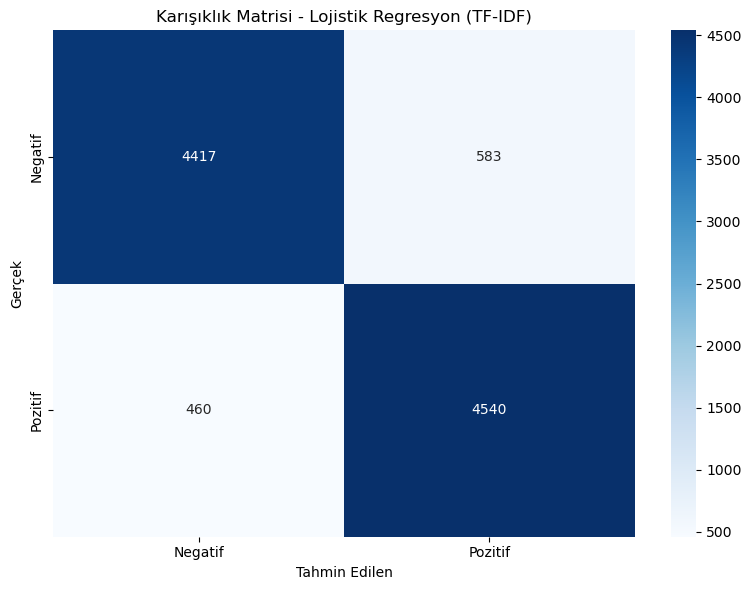

<Figure size 1200x800 with 0 Axes>

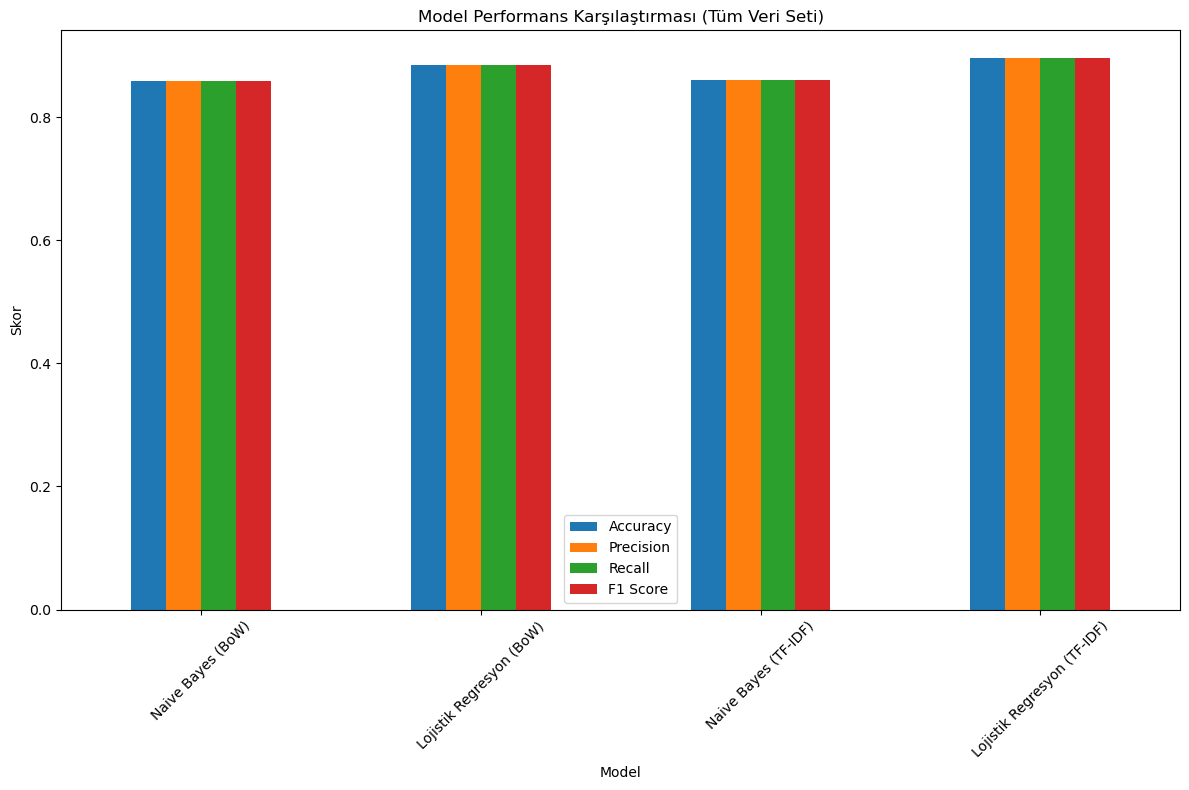

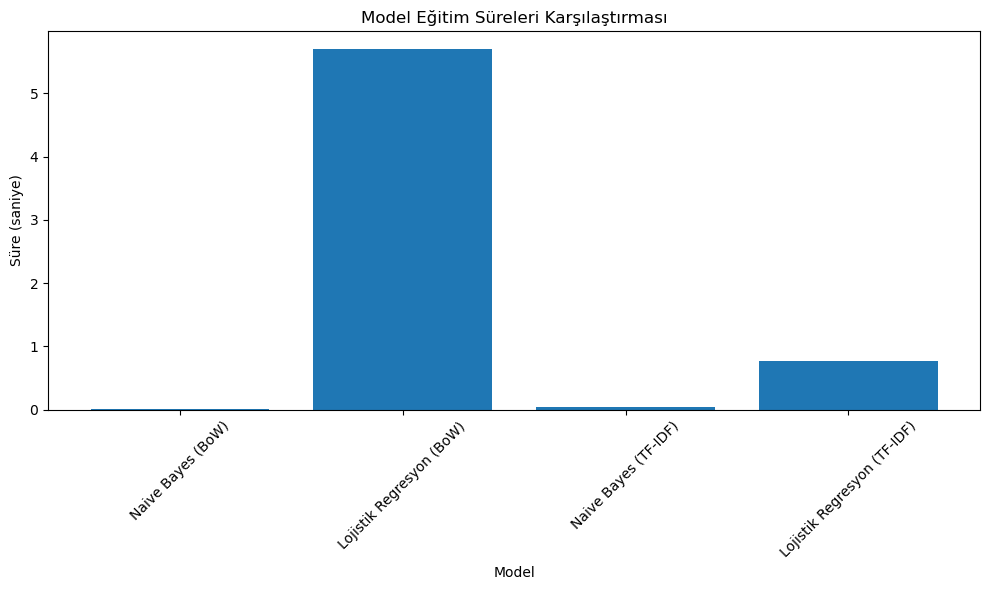

In [8]:
# ## 6. Performans Görselleştirme

# %% [code]
# Karışıklık matrisi
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_model_info['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negatif', 'Pozitif'], 
            yticklabels=['Negatif', 'Pozitif'])
plt.title(f'Karışıklık Matrisi - {best_model_name}')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.tight_layout()
plt.show()

# Performans metrikleri karşılaştırması
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.drop('training_time', axis=1)  # Eğitim süresini çıkar

plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performans Karşılaştırması (Tüm Veri Seti)')
plt.ylabel('Skor')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1 Score'])
plt.tight_layout()
plt.show()

# Eğitim süreleri karşılaştırması
training_times = {name: results[name]['training_time'] for name in results}
plt.figure(figsize=(10, 6))
plt.bar(training_times.keys(), training_times.values())
plt.title('Model Eğitim Süreleri Karşılaştırması')
plt.ylabel('Süre (saniye)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# ## 7. Test Sonuçlarını Kaydetme

# %% [code]
# Test sonuçlarını kaydet
test_results = pd.DataFrame({
    'Gerçek': y_test.values,
    'Tahmin': best_model_info['predictions'],
    'Doğru_Tahmin': y_test.values == best_model_info['predictions']
})

try:
    test_results.to_csv('../data/test_results_full.csv', index=False)
    print("✅ Test sonuçları '../data/test_results_full.csv' dosyasına kaydedildi.")
except Exception as e:
    print(f"❌ Test sonuçları kaydedilirken hata: {e}")

# Tüm model sonuçlarını kaydet
all_results = pd.DataFrame(results).T
try:
    all_results.to_csv('../data/all_model_results_full.csv')
    print("✅ Tüm model sonuçları '../data/all_model_results_full.csv' dosyasına kaydedildi.")
except Exception as e:
    print(f"❌ Tüm model sonuçları kaydedilirken hata: {e}")


✅ Test sonuçları '../data/test_results_full.csv' dosyasına kaydedildi.
✅ Tüm model sonuçları '../data/all_model_results_full.csv' dosyasına kaydedildi.


In [10]:
# ## 8. Özet ve Yükleme Talimatları

# %% [code]
print(f"\n🎯 ÖZET RAPOR:")
print("="*60)
print(f"📊 Veri Seti Boyutu: {X_bow.shape[0]} örnek")
print(f"📊 Toplam Özellik Sayısı: {X_bow.shape[1]} kelime")
print(f"📊 Eğitim Seti: {X_bow_train.shape[0]} örnek")
print(f"📊 Test Seti: {X_bow_test.shape[0]} örnek")
print(f"🏆 En İyi Model: {best_model_name}")
print(f"🎯 En İyi F1 Skoru: {best_model_results['f1']:.4f}")
print(f"🎯 En İyi Accuracy: {best_model_results['accuracy']:.4f}")
print(f"⏱️ En İyi Model Eğitim Süresi: {best_model_results['training_time']:.2f} saniye")

print(f"\n📁 Kaydedilen Dosyalar:")
print("• ../data/best_model_full.pkl - En iyi model")
print("• ../data/model_info_full.pkl - Model bilgileri")
print("• ../data/test_results_full.csv - Test sonuçları")
print("• ../data/all_model_results_full.csv - Tüm model performansları")

print(f"\n📖 Kaydedilen En İyi Modeli Yükleme:")
print("```python")
print("import pickle")
print("import scipy.sparse as sp")
print("")
print("# En iyi modeli yükle")
print("with open('../data/best_model_full.pkl', 'rb') as f:")
print("    best_model = pickle.load(f)")
print("")
print("# Model bilgilerini yükle")
print("with open('../data/model_info_full.pkl', 'rb') as f:")
print("    model_info = pickle.load(f)")
print("")
print("# Sparse vektörleri yükle")
if 'BoW' in best_model_name:
    print("X_test = sp.load_npz('../data/X_bow_full_sparse.npz')")
else:
    print("X_test = sp.load_npz('../data/X_tfidf_full_sparse.npz')")
print("")
print("# Tahmin yap")
print("predictions = best_model.predict(X_test)")
print("```")

print(f"\n🚀 Model Hazır! Artık gerçek metinlerde tahmin yapabilirsiniz!")
print("💡 Sparse matrisler kullanıldığı için bellek kullanımı optimize edildi.")
print("💡 Tüm veri seti kullanıldığı için model performansı maksimize edildi.")


🎯 ÖZET RAPOR:
📊 Veri Seti Boyutu: 50000 örnek
📊 Toplam Özellik Sayısı: 29165 kelime
📊 Eğitim Seti: 40000 örnek
📊 Test Seti: 10000 örnek
🏆 En İyi Model: Lojistik Regresyon (TF-IDF)
🎯 En İyi F1 Skoru: 0.8957
🎯 En İyi Accuracy: 0.8957
⏱️ En İyi Model Eğitim Süresi: 0.77 saniye

📁 Kaydedilen Dosyalar:
• ../data/best_model_full.pkl - En iyi model
• ../data/model_info_full.pkl - Model bilgileri
• ../data/test_results_full.csv - Test sonuçları
• ../data/all_model_results_full.csv - Tüm model performansları

📖 Kaydedilen En İyi Modeli Yükleme:
```python
import pickle
import scipy.sparse as sp

# En iyi modeli yükle
with open('../data/best_model_full.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Model bilgilerini yükle
with open('../data/model_info_full.pkl', 'rb') as f:
    model_info = pickle.load(f)

# Sparse vektörleri yükle
X_test = sp.load_npz('../data/X_tfidf_full_sparse.npz')

# Tahmin yap
predictions = best_model.predict(X_test)
```

🚀 Model Hazır! Artık gerçek metinlerde tahmi